In [1]:
!pip install tensorflow

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_folder = '/content/drive/MyDrive/data/images'
mask_folder = '/content/drive/MyDrive/data/labels'


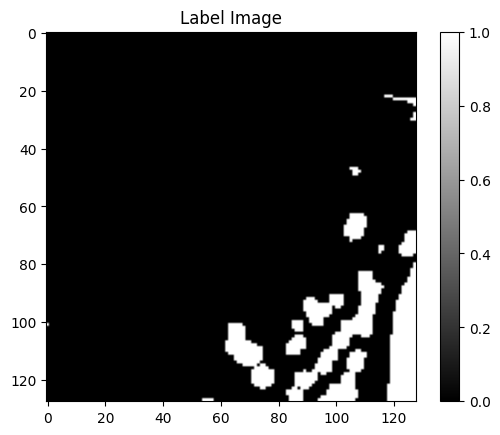

Unique pixel values in label: [0 1]


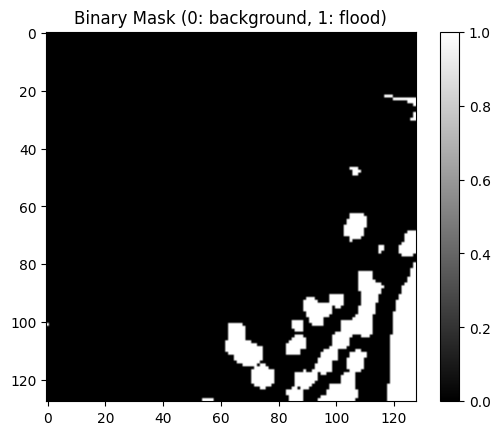

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load a label image
label_path = '/content/drive/MyDrive/data/labels/178.png'
label = Image.open(label_path).convert('L')  # 'L' mode = grayscale
label_np = np.array(label)

# Show image
plt.imshow(label_np, cmap='gray')
plt.title('Label Image')
plt.colorbar()
plt.show()

# Print unique values
print("Unique pixel values in label:", np.unique(label_np))
plt.imshow(label_np, cmap='gray', vmin=0, vmax=1)
plt.title('Binary Mask (0: background, 1: flood)')
plt.colorbar()
plt.show()


In [5]:
!pip install tifffile


In [6]:
import os
import numpy as np
import tifffile
from PIL import Image
from tensorflow.keras.utils import Sequence

class FloodDataset(Sequence):
    def __init__(self, image_dir, mask_dir, image_names, mask_names, batch_size=8, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_names) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_names))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        masks = []

        for idx in batch_indices:
            img_path = os.path.join(self.image_dir, self.image_names[idx])
            mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

            # Load and normalize image: shape [128, 128, 12]
            image = tifffile.imread(img_path).astype(np.float32) / 255.0
            if image.shape[0] == 12:  # in case it's [12, 128, 128], transpose it
                image = np.transpose(image, (1, 2, 0))

            # Load and binarize mask: shape [128, 128]
            mask = np.array(Image.open(mask_path)).astype(np.float32)
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)  # make shape [128, 128, 1]

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)


In [7]:
import tifffile

# Load a sample image
image_path = '/content/drive/MyDrive/data/images/137.tif'
image = tifffile.imread(image_path)

print("Image shape:", image.shape)


Image shape: (128, 128, 12)


In [8]:
# class FloodDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.image_names = sorted(os.listdir(image_dir))  # ensure matching order
#         self.mask_names = sorted(os.listdir(mask_dir))

#     def __len__(self):
#         return len(self.image_names)

#     def __getitem__(self, idx):
#         # Load 12-band image as numpy array
#         img_path = os.path.join(self.image_dir, self.image_names[idx])
#         mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

#         # Load image (expecting .npy or .tif or multi-band format)
#         image = np.load(img_path) if img_path.endswith('.npy') else np.array(Image.open(img_path))
#         mask = np.array(Image.open(mask_path))

#         # Normalize image to [0, 1]
#         image = image.astype(np.float32) / 255.0
#         mask = (mask > 0).astype(np.float32)  # Binary mask

#         # Convert to tensors
#         image = torch.from_numpy(image).permute(2, 0, 1)  # shape: [12, 128, 128]
#         mask = torch.from_numpy(mask).unsqueeze(0)        # shape: [1, 128, 128]

#         return image, mask


In [9]:
import numpy as np
import os

# List all files (make sure they're sorted)
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Create indices and shuffle
indices = np.arange(len(image_files))
np.random.shuffle(indices)

# Split indices into train and validation
train_size = int(0.7 * len(indices))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create file lists for train and val
train_images = [image_files[i] for i in train_indices]
train_masks = [mask_files[i] for i in train_indices]

val_images = [image_files[i] for i in val_indices]
val_masks = [mask_files[i] for i in val_indices]




In [10]:
train_dataset = FloodDataset(image_folder, mask_folder, train_images, train_masks, batch_size=8, shuffle=True)
val_dataset = FloodDataset(image_folder, mask_folder, val_images, val_masks, batch_size=8, shuffle=False)


In [11]:
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [12]:
def ConvBlock(inputs, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)

    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)

    return act2

In [13]:
def encoder(inputs, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [14]:
# Building the decoder
def decoder(inputs, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out

In [15]:
def get_U_Net(image_size):
    inputs = layers.Input(image_size)

    # Construct the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Preparing the next block
    conv_block = ConvBlock(encoder_4, 64*16)

    # Construct the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)


    model = models.Model(inputs, outputs)
    return model

In [16]:
input_shape=(128, 128, 12)
model = get_U_Net(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [17]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coef])


In [18]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.5985 - dice_coef: 0.3382 - loss: 0.7234 - val_accuracy: 0.6733 - val_dice_coef: 0.0751 - val_loss: 12.7636
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.6896 - dice_coef: 0.2979 - loss: 0.6332 - val_accuracy: 0.3324 - val_dice_coef: 0.4673 - val_loss: 94.6913
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.6710 - dice_coef: 0.3211 - loss: 0.6416 - val_accuracy: 0.6659 - val_dice_coef: 0.3112 - val_loss: 1.0154
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.7012 - dice_coef: 0.2956 - loss: 0.6120 - val_accuracy: 0.6862 - val_dice_coef: 0.2940 - val_loss: 0.6534
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.6916 - dice_coef: 0.3088 - loss: 0.6207 - val_accuracy: 0.6837 - val_dice_coef: 0.1995 - val_loss: 1.4955
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.6905 - dice_coef: 0.2954 - loss: 0.6275 - val_accuracy: 0.6420 - val_dic

In [20]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.6693 - dice_coef: 0.3271 - loss: 0.6386 - val_accuracy: 0.6864 - val_dice_coef: 0.2949 - val_loss: 0.6477
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.7149 - dice_coef: 0.2834 - loss: 0.5992 - val_accuracy: 0.6343 - val_dice_coef: 0.3452 - val_loss: 0.6594
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.6978 - dice_coef: 0.3060 - loss: 0.6177 - val_accuracy: 0.6860 - val_dice_coef: 0.3039 - val_loss: 0.6248
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.6738 - dice_coef: 0.3146 - loss: 0.6319 - val_accuracy: 0.6805 - val_dice_coef: 0.3195 - val_loss: 0.6265
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.6438 - dice_coef: 0.3278 - loss: 0.6599 - val_accuracy: 0.6755 - val_dice_coef: 0.3185 - val_loss: 0.6310
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.6868 - dice_coef: 0.2863 - loss: 0.6239 - val_accuracy: 0.5405 - val_dic

In [21]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.6931 - dice_coef: 0.2941 - loss: 0.6181 - val_accuracy: 0.6441 - val_dice_coef: 0.3397 - val_loss: 0.6509
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.7030 - dice_coef: 0.3021 - loss: 0.6085 - val_accuracy: 0.6814 - val_dice_coef: 0.2988 - val_loss: 0.6348
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.7086 - dice_coef: 0.2983 - loss: 0.6057 - val_accuracy: 0.6802 - val_dice_coef: 0.3295 - val_loss: 0.6352
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.6943 - dice_coef: 0.2986 - loss: 0.6154 - val_accuracy: 0.6820 - val_dice_coef: 0.3131 - val_loss: 0.6247
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.6811 - dice_coef: 0.3165 - loss: 0.6246 - val_accuracy: 0.6834 - val_dice_coef: 0.3082 - val_loss: 0.6215
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.7109 - dice_coef: 0.2796 - loss: 0.5997 - val_accuracy: 0.6683 - val_dic

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


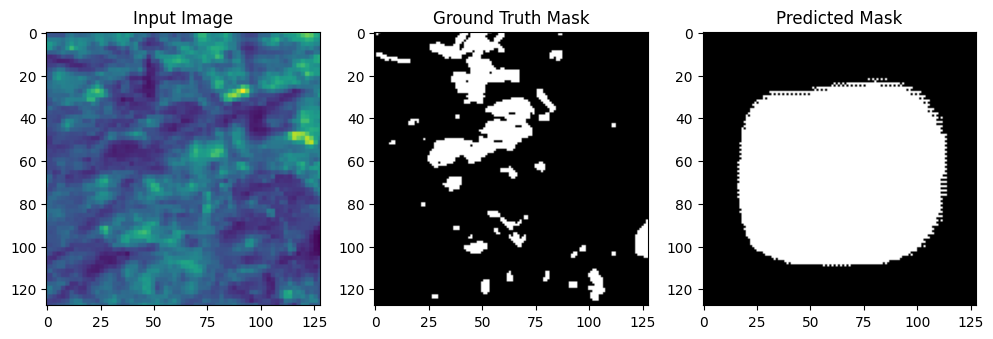

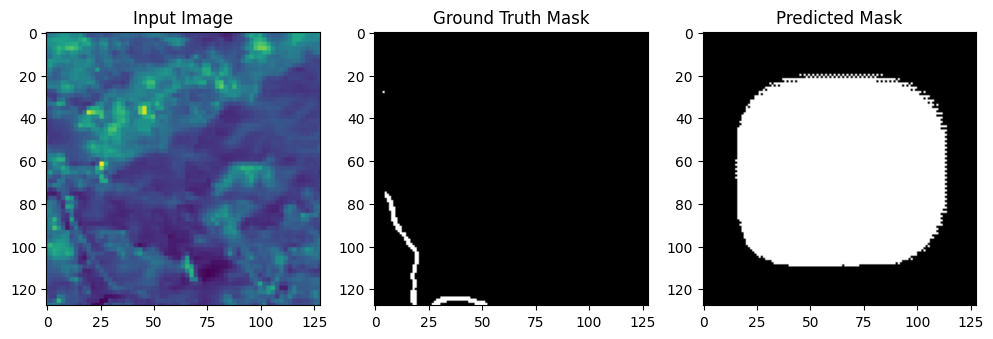

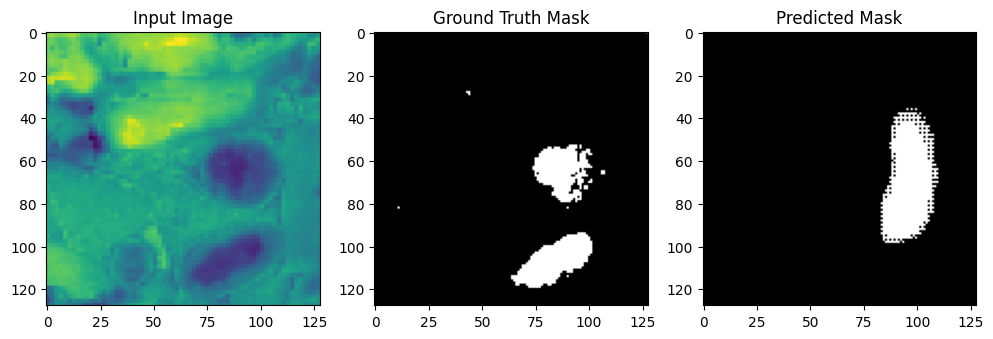

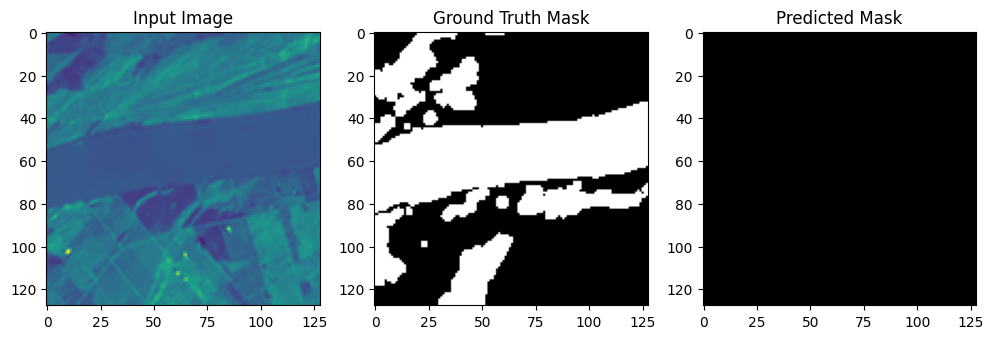

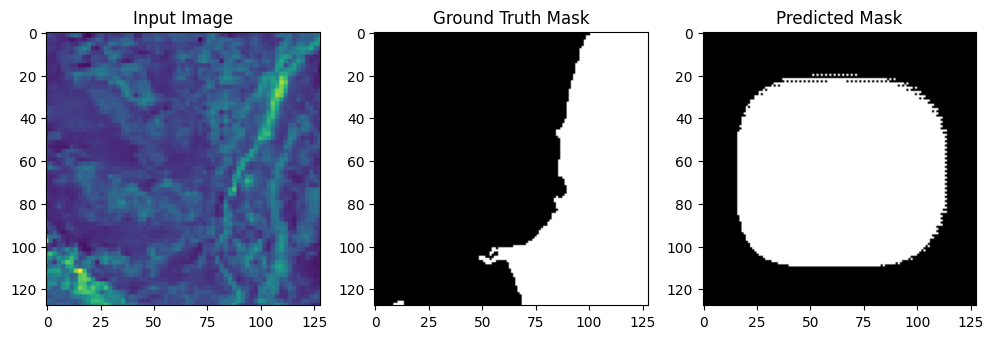

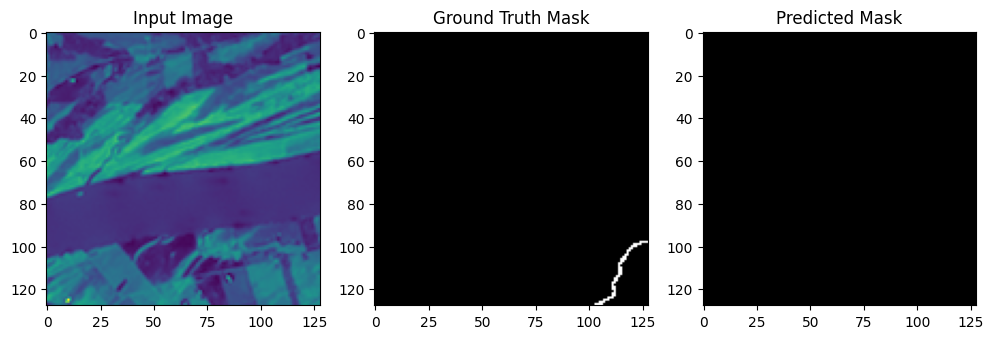

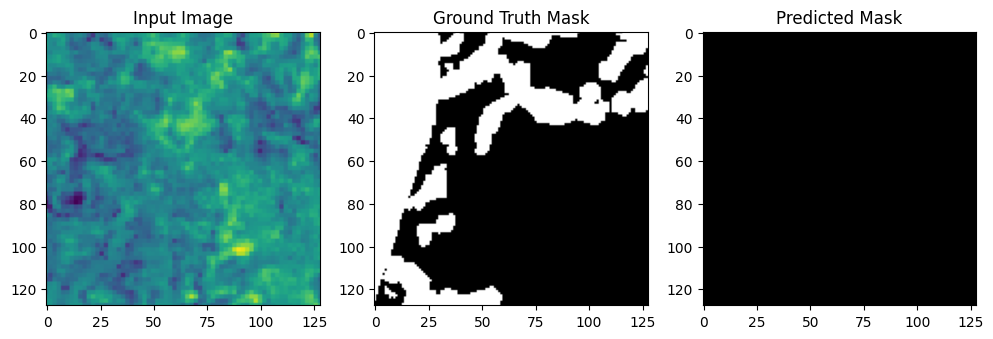

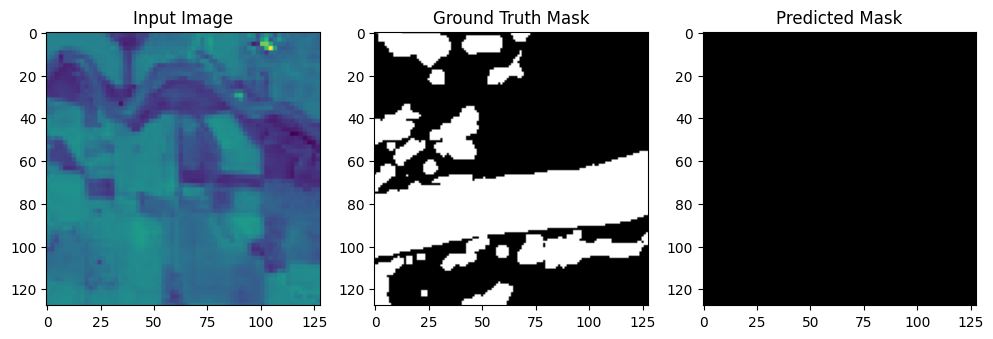

In [22]:
import matplotlib.pyplot as plt
for images, masks in val_dataset:
    preds = model.predict(images)
    for i in range(len(images)):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title('Input Image')
        plt.imshow(images[i][:,:,0])  # visualize first channel or RGB composite if applicable
        plt.subplot(1,3,2)
        plt.title('Ground Truth Mask')
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')  # threshold sigmoid output
        plt.show()
    break
